**Importing necessary libraries and loading the dataset**

In this step, we prepared Python environment with the necessary libraries and loaded the data into a pandas DataFrame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
df = pd.read_csv("/content/netflix_titles.csv")

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


**Data Cleaning**

 We filled the missing values in the 'director', 'cast', 'country', 'rating', and 'date_added' columns. For 'director' and 'cast', we replaced missing values with 'Unknown'. For 'country' and 'rating', we used the most frequent value (mode), and for 'date_added', we filled in the most common date.

In [5]:
# 1. Handle Missing Data:
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna(df['country'].mode()[0], inplace=True)
df['rating'].fillna(df['rating'].mode()[0], inplace=True)
df['date_added'].fillna(df['date_added'].mode()[0], inplace=True)

**Data Transformation**

We transformed the 'date_added' column into a datetime object, then we extracted the year and month from 'date_added' and created new columns for them.

In [6]:
# 2. Convert Data Types:
df['date_added'] = pd.to_datetime(df['date_added'])

# 3. Extract Year and Month from 'date_added'
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

**Exploratory Data Analysis (EDA)**

In this step, we explored the data by visualizing the distribution of content types and ratings.

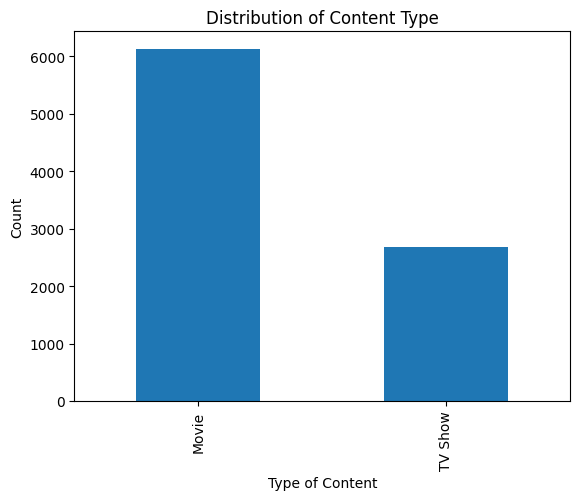

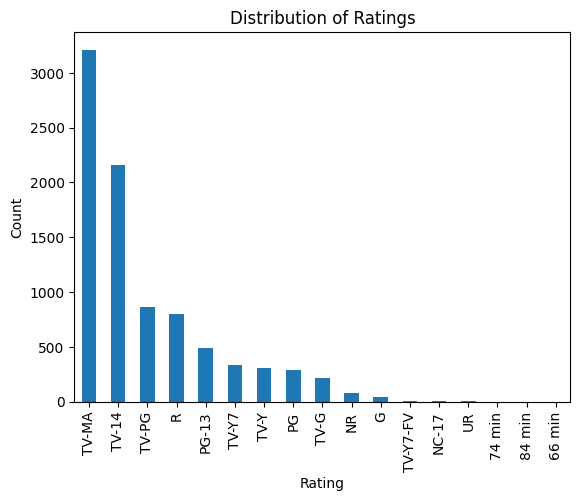

In [7]:
# Distribution of the types of content on Netflix
df['type'].value_counts().plot(kind='bar')
plt.title("Distribution of Content Type")
plt.xlabel("Type of Content")
plt.ylabel("Count")
plt.show()

# Distribution of the ratings of content on Netflix
df['rating'].value_counts().plot(kind='bar')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

**Feature Engineering**

We created new features, 'duration_min' and 'seasons', from the 'duration' column, and then dropped the original 'duration' column.

In [8]:
# From 'duration' column, differentiate between movies and TV shows
df['duration_min'] = df.loc[df['type'] == 'Movie', 'duration'].str.extract('(\d+)').astype(float)
df['seasons'] = df.loc[df['type'] == 'TV Show', 'duration'].str.extract('(\d+)').astype(float)

# Fill the missing values in 'duration_min' and 'seasons' with 0
df[['duration_min', 'seasons']] = df[['duration_min', 'seasons']].fillna(0)

# Drop the original 'duration' column
df = df.drop('duration', axis=1)

**Creating the Content Feature**

We combine several text features into a single string ('content'), which will be used to compute similarity between movies/shows.

In [9]:
# Combine important features into a single string for recommendation system
df['content'] = df['title'] + ' ' + df['director'] + ' ' + df['cast'] + ' ' + df['listed_in'] + ' ' + df['description']

**TF-IDF Transformation and Cosine Similarity Calculation**

We transformed our 'content' into a matrix of TF-IDF features. Then, using this TF-IDF matrix, we computed the cosine similarity matrix. This matrix indicates the cosine of the angle between the TF-IDF vectors of each pair of movies/shows, which is a measure of how similar the movies/shows are to each other.

In [10]:
# Create a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['content'])
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

**Recommendation Function**

We wrote a function named get_recommendations(), which takes a movie/show title and cosine similarity matrix as input, and returns the 10 most similar movies/shows to the given title. The function operates as follows:

First, it retrieves the index of the movie/show that matches the provided
title.

Next, it gets the pairwise similarity scores for all movies/shows with the selected movie/show, and sorts these scores.

The top 10 most similar movies/shows (not including the given movie/show itself) are selected based on these scores.

Finally, the function returns the titles of these top 10 most similar movies/shows.

In [11]:
# Function to get recommendation
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = df[df['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

**Getting Recommendations**

The final part of the code is about getting recommendations by providing the title of a specific movie or show. We tested this by inputting a sample movie/show name and examining the output.

In [12]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Check if the title exists in the DataFrame
    if title not in df['title'].values:
        return "The title is not in the database. Please try another one."
    else:
        # Get the index of the movie that matches the title
        idx = df[df['title'] == title].index[0]

        # Get the pairwise similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        return df['title'].iloc[movie_indices]

# Get user input
user_movie = input("Enter the name of a movie or show: ")

# Get recommendations
recommendations = get_recommendations(user_movie)

# Display the recommendations
if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"\nMovies/Shows similar to {user_movie}:\n")
    for i, rec in enumerate(recommendations):
        print(f"{i+1}: {rec}")

Enter the name of a movie or show: Inception

Movies/Shows similar to Inception:

1: Peaky Blinders
2: Before the Flood
3: Brick
4: Mars Attacks!
5: Dragonheart
6: Sniper: Legacy
7: Catch Me If You Can
8: Solomon Kane
9: Dead in a Week (Or Your Money Back)
10: Dragonheart: A New Beginning
